In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping

from preprocess import get_hinge_features
from preprocess import get_chain_code_features
from preprocess import preprocessing

import cv2
from PIL import Image

from tqdm import tqdm 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split

데이터 불러오고 train / valid / test 나누기

In [2]:
#데이터 불러오기
#데이터 개수 총 1900개 => 6:2:2 = 1140 , 190 ,570

from_path = 'new_cut/'
data = []
for i in tqdm(range(1,476)):
    for j in range(1,5):
        image_path = str(i).zfill(4) + '_' + str(j) +'.jpg'
        #흑백으로 불러오기
        img = cv2.imread(from_path + image_path, cv2.IMREAD_GRAYSCALE)
        data.append(img)
        
y = np.load('new_y.npy')
data = np.array(data)
print(data.shape,y.shape)

 36%|███▌      | 170/475 [00:07<00:12, 23.89it/s]


KeyboardInterrupt: 

In [ ]:
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)
x_train_data, x_valid_data, y_train_data, y_valid_data = train_test_split(x_train_data, y_train_data, test_size=0.25, shuffle=True, random_state=42)
print(f'train data : {x_train_data.shape} {y_train_data.shape}')
print(f'valid data : {x_valid_data.shape} {y_valid_data.shape}')
print(f'test data : {x_test_data.shape} {y_test_data.shape}')

#0.자르지 않고 resize 후 CNN

In [7]:
#x_size 세로 y_size 가로
x_size = 200
y_size = 200

#데이터 불러오기
#데이터 개수 총 1900개 => 6:2:2 = 1140 , 190 ,570

from_path = 'new_cut/'
data = []
for i in tqdm(range(1,476)):
    for j in range(1,5):
        image_path = str(i).zfill(4) + '_' + str(j) +'.jpg'
        #흑백으로 불러오기
        img = cv2.imread(from_path + image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(x_size,y_size))
        data.append(img)
        
y = np.load('new_y.npy')
data = np.array(data)
print(data.shape,y.shape)

100%|██████████| 475/475 [00:16<00:00, 28.48it/s]

(1900, 200, 200) (1900,)


In [8]:
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)
x_train_data, x_valid_data, y_train_data, y_valid_data = train_test_split(x_train_data, y_train_data, test_size=0.25, shuffle=True, random_state=42)
print(f'train data : {x_train_data.shape} {y_train_data.shape}')
print(f'valid data : {x_valid_data.shape} {y_valid_data.shape}')
print(f'test data : {x_test_data.shape} {y_test_data.shape}')

train data : (1140, 200, 200) (1140,)
valid data : (380, 200, 200) (380,)
test data : (380, 200, 200) (380,)


In [9]:
#모델 생성
tf.random.set_seed(42)

# Normalizing data
x_train, x_valid, x_test = x_train_data / 255.0 , x_valid_data/255.0 , x_test_data / 255.0

In [10]:
model = tf.keras.Sequential([
    #첫번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, input_shape=(x_size,y_size,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    
    
    #두번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    #세번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.6),
    
    #네번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.6),
    

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 128)       0

C:\Users\minki\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=5, verbose=0, mode='auto')
model.fit(x_train, y_train_data, batch_size=128, epochs=500, validation_data=(x_valid, y_valid_data),callbacks=[early_stopping])

Epoch 1/500
9/9 [==============================] - 14s 722ms/step - loss: 0.9553 - accuracy: 0.5526 - val_loss: 0.6932 - val_accuracy: 0.4632
Epoch 2/500
9/9 [==============================] - 3s 338ms/step - loss: 0.6914 - accuracy: 0.5421 - val_loss: 0.6933 - val_accuracy: 0.4632
Epoch 3/500
9/9 [==============================] - 3s 333ms/step - loss: 0.6921 - accuracy: 0.5412 - val_loss: 0.6933 - val_accuracy: 0.4632
Epoch 4/500
9/9 [==============================] - 3s 332ms/step - loss: 0.6927 - accuracy: 0.5360 - val_loss: 0.6932 - val_accuracy: 0.4632
Epoch 5/500
9/9 [==============================] - 3s 335ms/step - loss: 0.6908 - accuracy: 0.5421 - val_loss: 0.6931 - val_accuracy: 0.5368
Epoch 6/500
9/9 [==============================] - 5s 535ms/step - loss: 0.6904 - accuracy: 0.5421 - val_loss: 0.6930 - val_accuracy: 0.5368
Epoch 7/500
9/9 [==============================] - 5s 625ms/step - loss: 0.6927 - accuracy: 0.5430 - val_loss: 0.6930 - val_accuracy: 0.5368
Epoch 8/500


In [12]:
pred = model.predict(x_test)
pred

12/12 [==============================] - 1s 56ms/step


array([[0.49511495],
       [0.49551225],
       [0.49417147],
       [0.49398667],
       [0.49470064],
       [0.49537465],
       [0.49504262],
       [0.4947747 ],
       [0.4953806 ],
       [0.49452677],
       [0.49514443],
       [0.4956062 ],
       [0.49475485],
       [0.4951892 ],
       [0.49530333],
       [0.4951471 ],
       [0.4950983 ],
       [0.4952879 ],
       [0.49460912],
       [0.4953233 ],
       [0.4944729 ],
       [0.49565944],
       [0.4949756 ],
       [0.49520317],
       [0.49339262],
       [0.49514103],
       [0.49488443],
       [0.49541995],
       [0.4947286 ],
       [0.4951325 ],
       [0.49528134],
       [0.49450016],
       [0.494834  ],
       [0.4925998 ],
       [0.49444246],
       [0.49498922],
       [0.4951104 ],
       [0.49550182],
       [0.49464607],
       [0.49486896],
       [0.4949571 ],
       [0.4946    ],
       [0.49526042],
       [0.49485806],
       [0.49530113],
       [0.49547103],
       [0.49587932],
       [0.493

In [13]:
pred = model.predict(x_test)
pred = list(map(lambda x: 1 if x>=0.5 else 0,pred))
print('Accuracy:', accuracy_score(y_test_data, pred)*100, '%')

12/12 [==============================] - 0s 20ms/step
Accuracy: 51.05263157894737 %


In [14]:
pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


1. 데이터 증강 없이 CNN  
crop

In [2]:
#데이터 불러오기
#데이터 개수 총 1900개 => 6:2:2 = 1140 , 380 ,380

from_path = 'new/'
data = []
for i in tqdm(range(1,476)):
    for j in range(1,5):
        image_path = str(i).zfill(4) + '_' + str(j) +'.jpg'
        #흑백으로 불러오기
        img = cv2.imread(from_path + image_path, cv2.IMREAD_GRAYSCALE)
        #img = cv2.GaussianBlur(img,(5,5),0)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
        data.append(img)
        
y = np.load('new_y.npy')
data = np.array(data)
print(data.shape,y.shape)

x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)
x_train_data, x_valid_data, y_train_data, y_valid_data = train_test_split(x_train_data, y_train_data, test_size=0.25, shuffle=True, random_state=42)
print(f'train data : {x_train_data.shape} {y_train_data.shape}')
print(f'valid data : {x_valid_data.shape} {y_valid_data.shape}')
print(f'test data : {x_test_data.shape} {y_test_data.shape}')

100%|██████████| 475/475 [10:18<00:00,  1.30s/it]

(1900,) (1900,)
train data : (1140,) (1140,)
valid data : (380,) (380,)
test data : (380,) (380,)



<ipython-input-2-830353ddc364>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [3]:
#영어로만
from_path = 'new_cut/'
data = []
for i in tqdm(range(1,476)):
    for j in range(3,5):
        image_path = str(i).zfill(4) + '_' + str(j) +'.jpg'
        #흑백으로 불러오기
        img = cv2.imread(from_path + image_path, cv2.IMREAD_GRAYSCALE)
        #img = cv2.GaussianBlur(img,(5,5),0)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
        data.append(img)

100%|██████████| 475/475 [01:51<00:00,  4.26it/s]


In [4]:
data = np.array(data)
data.shape

<ipython-input-4-597b31f3bbba>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


(950,)

In [5]:
y_list = np.load('new_y.npy')

y = []

for i,v in enumerate(y_list):
    if i%4>=2:
        y.append(v)

In [6]:
y=np.array(y)
y.shape

(950,)

In [7]:
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)
x_train_data, x_valid_data, y_train_data, y_valid_data = train_test_split(x_train_data, y_train_data, test_size=0.25, shuffle=True, random_state=42)
print(f'train data : {x_train_data.shape} {y_train_data.shape}')
print(f'valid data : {x_valid_data.shape} {y_valid_data.shape}')
print(f'test data : {x_test_data.shape} {y_test_data.shape}')

train data : (570,) (570,)
valid data : (190,) (190,)
test data : (190,) (190,)


In [8]:
#x_size 세로 y_size 가로
x_size = 256
y_size = 512

In [9]:
#y는 y_train_data , y_valid_data , y_test_data그대로 사용하면 됨

x_train = []
x_valid = []
x_test = []

for v in x_train_data:
    # x_width는 세로 , y_width는 가로
    x_width , y_width = v.shape[0] , v.shape[1]
    v = v[(x_width - x_size)//2 : (x_width - x_size)//2 + x_size , (y_width - y_size)//2 : (y_width - y_size)//2 + y_size ]
    v = cv2.resize(v,(x_size//4,y_size//4)).reshape(x_size//4,y_size//4,1)
    x_train.append(v)
    
for v in x_valid_data:
    # x_width는 세로 , y_width는 가로
    x_width , y_width = v.shape[0] , v.shape[1]
    v = v[(x_width - x_size)//2 : (x_width - x_size)//2 + x_size , (y_width - y_size)//2 : (y_width - y_size)//2 + y_size ]
    v = cv2.resize(v,(x_size//4,y_size//4)).reshape(x_size//4,y_size//4,1)
    x_valid.append(v)
    
for v in x_test_data:
    # x_width는 세로 , y_width는 가로
    x_width , y_width = v.shape[0] , v.shape[1]
    v = v[(x_width - x_size)//2 : (x_width - x_size)//2 + x_size , (y_width - y_size)//2 : (y_width - y_size)//2 + y_size ]
    v = cv2.resize(v,(x_size//4,y_size//4)).reshape(x_size//4,y_size//4,1)
    x_test.append(v)
    
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

x_train.shape , x_valid.shape , x_test.shape

((570, 64, 128, 1), (190, 64, 128, 1), (190, 64, 128, 1))

In [10]:
#모델 생성
tf.random.set_seed(42)

# Normalizing data
x_train, x_valid, x_test = x_train / 255.0 , x_valid/255.0 , x_test / 255.0

In [11]:
model = tf.keras.Sequential([
    #첫번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, input_shape=(x_size//4,y_size//4,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    
    
    #두번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    #세번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.6),
    
    #네번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.6),
    

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.RMSprop(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 32, 128)       0

C:\Users\minki\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, verbose=0, mode='auto')
hist = model.fit(x_train, y_train_data, batch_size=32, epochs=500, validation_data=(x_valid, y_valid_data),callbacks=[early_stopping])

Epoch 1/500
18/18 [==============================] - 10s 46ms/step - loss: 0.8358 - accuracy: 0.5246 - val_loss: 0.6932 - val_accuracy: 0.4421
Epoch 2/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6938 - accuracy: 0.5421 - val_loss: 0.6923 - val_accuracy: 0.5579
Epoch 3/500
18/18 [==============================] - 0s 15ms/step - loss: 0.7031 - accuracy: 0.5246 - val_loss: 0.6925 - val_accuracy: 0.5579
Epoch 4/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6926 - accuracy: 0.5281 - val_loss: 0.6866 - val_accuracy: 0.5579
Epoch 5/500
18/18 [==============================] - 0s 15ms/step - loss: 0.7039 - accuracy: 0.5263 - val_loss: 0.6915 - val_accuracy: 0.5579
Epoch 6/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6910 - accuracy: 0.5263 - val_loss: 0.6914 - val_accuracy: 0.5579
Epoch 7/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.5386 - val_loss: 0.6907 - val_accuracy: 0.5579
Epoch

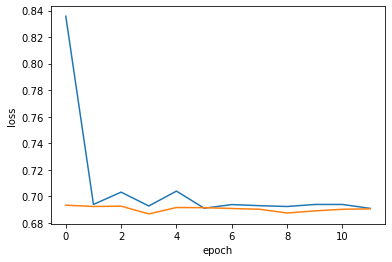

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [14]:
result = model.evaluate(x_test, y_test_data)
print("최종 예측 성공률(%): ", result[1]*100)

6/6 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4842
최종 예측 성공률(%):  48.42105209827423


In [15]:
pred = model.predict(x_test)
pred = list(map(lambda x: 1 if x>=0.5 else 0,pred))
print('Accuracy:', accuracy_score(y_test_data, pred)*100, '%')

6/6 [==============================] - 0s 4ms/step
Accuracy: 48.421052631578945 %


In [16]:
pred = model.predict(x_test)
pred

6/6 [==============================] - 0s 4ms/step


array([[0.486591  ],
       [0.48710656],
       [0.48855746],
       [0.48849624],
       [0.48790514],
       [0.48783717],
       [0.4881372 ],
       [0.48827377],
       [0.48720273],
       [0.48739114],
       [0.48794308],
       [0.48793054],
       [0.48784795],
       [0.48741385],
       [0.48814166],
       [0.48834485],
       [0.48769093],
       [0.48768646],
       [0.48800337],
       [0.48739314],
       [0.48757008],
       [0.48710757],
       [0.48778537],
       [0.4877131 ],
       [0.4876661 ],
       [0.4880713 ],
       [0.4874525 ],
       [0.4879341 ],
       [0.48785543],
       [0.48817286],
       [0.48775446],
       [0.48740938],
       [0.48791873],
       [0.48787826],
       [0.48775536],
       [0.4868813 ],
       [0.48742265],
       [0.48756316],
       [0.4874853 ],
       [0.48773903],
       [0.4869674 ],
       [0.4881925 ],
       [0.4885816 ],
       [0.4873052 ],
       [0.4883156 ],
       [0.4877936 ],
       [0.48903364],
       [0.488

논문처럼 구현  
데이터를 사진 하나당 200개로 (200x200)로 나누고 resize(50x50)으로 변경

In [17]:
#데이터 불러오기
#데이터 개수 총 1900개 => 6:2:2 = 1140 , 190 ,570

from_path = 'new_cut/'
data = []
for i in tqdm(range(1,476)):
    for j in range(1,5):
        image_path = str(i).zfill(4) + '_' + str(j) +'.jpg'
        #흑백으로 불러오기
        img = cv2.imread(from_path + image_path, cv2.IMREAD_GRAYSCALE)
        data.append(img)
        
y = np.load('new_y.npy')
data = np.array(data)
print(data.shape,y.shape)

x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)
x_train_data, x_valid_data, y_train_data, y_valid_data = train_test_split(x_train_data, y_train_data, test_size=0.25, shuffle=True, random_state=42)
print(f'train data : {x_train_data.shape} {y_train_data.shape}')
print(f'valid data : {x_valid_data.shape} {y_valid_data.shape}')
print(f'test data : {x_test_data.shape} {y_test_data.shape}')

100%|██████████| 475/475 [00:20<00:00, 22.83it/s]
<ipython-input-17-bb524b1490c0>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


(1900,) (1900,)
train data : (1140,) (1140,)
valid data : (380,) (380,)
test data : (380,) (380,)


In [18]:
x_train_data[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 254, 254, 254],
       [255, 255, 255, ..., 254, 254, 253],
       [255, 255, 255, ..., 255, 253, 250]], dtype=uint8)

In [19]:
#train data =>(1900 , 50 ,50 , 100)으로 바꾸는게 목표

x_train = np.array([]).reshape(-1,50,50,100)
x_valid = np.array([]).reshape(-1,50,50,100)
x_test = np.array([]).reshape(-1,50,50,100)

for img in tqdm(x_train_data):
    x_width , y_width = img.shape[0] , img.shape[1]
    data = np.array([]).reshape(50,50,-1)
    for i in np.linspace(0,x_width-200,10):
        for j in np.linspace(0,y_width-200,10):
            i , j = int(i) , int(j)
            t_img = img[i:i+200,j:j+200]
            t_img = Image.fromarray(t_img)
            t_img = t_img.resize((50,50))#이미지로 변환후 reshape
            t_img = np.array(t_img).reshape(50,50,1)
            data = np.concatenate((data,t_img),axis=2)
    x_train = np.concatenate((x_train,data.reshape(-1,50,50,100)),axis=0)
    
for img in tqdm(x_valid_data):
    x_width , y_width = img.shape[0] , img.shape[1]
    data = np.array([]).reshape(50,50,-1)
    for i in np.linspace(0,x_width-200,10):
        for j in np.linspace(0,y_width-200,10):
            i , j = int(i) , int(j)
            t_img = img[i:i+200,j:j+200]
            t_img = Image.fromarray(t_img)
            t_img = t_img.resize((50,50))#이미지로 변환후 reshape
            t_img = np.array(t_img).reshape(50,50,1)
            data = np.concatenate((data,t_img),axis=2)
    x_valid = np.concatenate((x_valid,data.reshape(-1,50,50,100)),axis=0)

for img in tqdm(x_test_data):
    x_width , y_width = img.shape[0] , img.shape[1]
    data = np.array([]).reshape(50,50,-1)
    for i in np.linspace(0,x_width-200,10):
        for j in np.linspace(0,y_width-200,10):
            i , j = int(i) , int(j)
            t_img = img[i:i+200,j:j+200]
            t_img = Image.fromarray(t_img)
            t_img = t_img.resize((50,50))#이미지로 변환후 reshape
            t_img = np.array(t_img).reshape(50,50,1)
            data = np.concatenate((data,t_img),axis=2)
    x_test = np.concatenate((x_test,data.reshape(-1,50,50,100)),axis=0)
    
#1140*50*50*100 / 380*50*50*100 / 380*50*50*100나와야 함
x_train.shape , x_valid.shape , x_test.shape

100%|██████████| 380/380 [00:49<00:00,  7.68it/s]


((1140, 50, 50, 100), (380, 50, 50, 100), (380, 50, 50, 100))

In [20]:
x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

In [21]:
model = tf.keras.Sequential([
    #첫번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, input_shape=(50,50,100), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    
    
    #두번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    #세번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.6),
    
    #네번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.6),
    

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.RMSprop(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        57664     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 128)      

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, verbose=0, mode='auto')
hist = model.fit(x_train, y_train_data, batch_size=32, epochs=500, validation_data=(x_valid, y_valid_data),callbacks=[early_stopping])

Epoch 1/500
36/36 [==============================] - 3s 45ms/step - loss: 1.0115 - accuracy: 0.4895 - val_loss: 0.6921 - val_accuracy: 0.5368
Epoch 2/500
36/36 [==============================] - 1s 27ms/step - loss: 0.7010 - accuracy: 0.5289 - val_loss: 0.6918 - val_accuracy: 0.5368
Epoch 3/500
36/36 [==============================] - 1s 29ms/step - loss: 0.6979 - accuracy: 0.5246 - val_loss: 0.6917 - val_accuracy: 0.5368
Epoch 4/500
36/36 [==============================] - 1s 28ms/step - loss: 0.6996 - accuracy: 0.5246 - val_loss: 0.6908 - val_accuracy: 0.5368
Epoch 5/500
36/36 [==============================] - 1s 28ms/step - loss: 0.6940 - accuracy: 0.5421 - val_loss: 0.6909 - val_accuracy: 0.5368
Epoch 6/500
36/36 [==============================] - 1s 27ms/step - loss: 0.6948 - accuracy: 0.5395 - val_loss: 0.6904 - val_accuracy: 0.5368
Epoch 7/500
36/36 [==============================] - 1s 32ms/step - loss: 0.6916 - accuracy: 0.5377 - val_loss: 0.6905 - val_accuracy: 0.5368
Epoch 

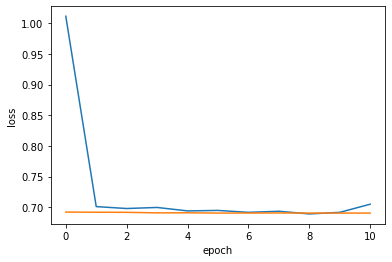

In [23]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [24]:
result = model.evaluate(x_test, y_test_data)
print("최종 예측 성공률(%): ", result[1]*100)

12/12 [==============================] - 0s 14ms/step - loss: 0.6943 - accuracy: 0.5105
최종 예측 성공률(%):  51.05262994766235


In [25]:
pred = model.predict(x_test)
pred

12/12 [==============================] - 0s 13ms/step


array([[0.46313593],
       [0.46307763],
       [0.46305296],
       [0.46314713],
       [0.46299356],
       [0.4630413 ],
       [0.4631414 ],
       [0.46303195],
       [0.46303353],
       [0.46306747],
       [0.4630646 ],
       [0.46313077],
       [0.4632193 ],
       [0.46338245],
       [0.4631719 ],
       [0.46298322],
       [0.46298978],
       [0.46318954],
       [0.46269763],
       [0.46300143],
       [0.46283242],
       [0.46325657],
       [0.46297443],
       [0.46320954],
       [0.46315932],
       [0.46312618],
       [0.46309027],
       [0.4631991 ],
       [0.4629456 ],
       [0.46309176],
       [0.46277595],
       [0.46320963],
       [0.46307698],
       [0.4626184 ],
       [0.46296513],
       [0.4632127 ],
       [0.46302223],
       [0.4632694 ],
       [0.4632453 ],
       [0.46282998],
       [0.46317485],
       [0.46286306],
       [0.4631051 ],
       [0.46322012],
       [0.46314743],
       [0.46299008],
       [0.46320513],
       [0.462

## 논문처럼 한개 사진을 200개로 나눠서 softmax(softmax구현 할줄 몰라서) 평균으로

In [46]:
#데이터 불러오기
#데이터 개수 총 1900개 => 6:2:2 = 1140 , 190 ,570

from_path = 'new_cut/'
data = []
for i in tqdm(range(1,476)):
    for j in range(1,5):
        image_path = str(i).zfill(4) + '_' + str(j) +'.jpg'
        #흑백으로 불러오기
        img = cv2.imread(from_path + image_path, cv2.IMREAD_GRAYSCALE)
        data.append(img)
        
y = np.load('new_y.npy')
data = np.array(data)
print(data.shape,y.shape)

x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(data, y, test_size=0.2, shuffle=True, random_state=42)
x_train_data, x_valid_data, y_train_data, y_valid_data = train_test_split(x_train_data, y_train_data, test_size=0.25, shuffle=True, random_state=42)
print(f'train data : {x_train_data.shape} {y_train_data.shape}')
print(f'valid data : {x_valid_data.shape} {y_valid_data.shape}')
print(f'test data : {x_test_data.shape} {y_test_data.shape}')

100%|██████████| 475/475 [00:18<00:00, 25.52it/s]
<ipython-input-46-bb524b1490c0>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


(1900,) (1900,)
train data : (1140,) (1140,)
valid data : (380,) (380,)
test data : (380,) (380,)


In [47]:
#train data =>(-1 , 50 ,50 , 1)으로 바꾸는게 목표

x_train = np.array([]).reshape(-1,50,50,1)
x_valid = np.array([]).reshape(-1,50,50,1)
x_test = np.array([]).reshape(-1,50,50,1)

y_train , y_valid , y_test = [] , [] , []

for idx , img in enumerate(tqdm(x_test_data)):
    x_width , y_width = img.shape[0] , img.shape[1]
    for i in np.linspace(0,x_width-200,5):
        for j in np.linspace(0,y_width-200,10):
            i , j = int(i) , int(j)
            #t_img = img[i:i+200,j:j+200]
            #t_img = cv2.resize(t_img,(50,50))#이미지로 변환후 reshape
            #x_test = np.append(x_test,t_img.reshape(-1,50,50,1),axis=0)
            y_test.append(y_test_data[idx])
            
print(x_test.shape)
for idx , img in enumerate(tqdm(x_train_data)):
    x_width , y_width = img.shape[0] , img.shape[1]
    for i in np.linspace(0,x_width-200,5):
        for j in np.linspace(0,y_width-200,10):
            #i , j = int(i) , int(j)
            #t_img = img[i:i+200,j:j+200]
            #t_img = cv2.resize(t_img,(50,50))#이미지로 변환후 reshape
            #x_train = np.append(x_train,t_img.reshape(-1,50,50,1),axis=0)
            y_train.append(y_train_data[idx])
    
for idx , img in enumerate(tqdm(x_valid_data)):
    x_width , y_width = img.shape[0] , img.shape[1]
    for i in np.linspace(0,x_width-200,5):
        for j in np.linspace(0,y_width-200,10):
            #i , j = int(i) , int(j)
            #t_img = img[i:i+200,j:j+200]
            #t_img = cv2.resize(t_img,(50,50))#이미지로 변환후 reshape
            #x_valid = np.append(x_valid,t_img.reshape(-1,50,50,1),axis=0)
            y_valid.append(y_valid_data[idx])
            
            
            
#(1140*100)*50*50*1 / (380*100)*50*50*1 / (380*100)*50*50*1 이나와야 함
print(x_train.shape , x_valid.shape , x_test.shape)
print(len(y_train),len(y_valid),len(y_test))

  0%|          | 0/1140 [00:00<?, ?it/s]

(0, 50, 50, 1)


100%|██████████| 380/380 [00:00<00:00, 6333.57it/s]

(0, 50, 50, 1) (0, 50, 50, 1) (0, 50, 50, 1)
57000 19000 19000


In [73]:
#np.save('train_cnn.npy',x_train)
#np.save('valid_cnn.npy',x_valid)
#np.save('test_cnn.npy',x_test)

In [48]:
x_train = np.load('train_cnn.npy')
x_valid = np.load('valid_cnn.npy')
x_test = np.load('test_cnn.npy')

In [49]:
x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

x_train = x_train.reshape(-1,50,50,1)
x_valid = x_valid.reshape(-1,50,50,1)
x_test = x_test.reshape(-1,50,50,1)
print(x_train.shape , x_valid.shape , x_test.shape)

(57000, 50, 50, 1) (19000, 50, 50, 1) (19000, 50, 50, 1)


In [50]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [51]:
model = tf.keras.Sequential([
    #첫번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, input_shape=(50,50,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    
    
    #두번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.4),

    #세번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.6),
    
    #네번째 층
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.6),
    

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 50, 50, 64)        640       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 25, 25, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 12, 12, 128)      

In [52]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, verbose=0, mode='auto')
hist = model.fit(x_train, y_train, batch_size=32, epochs=500, validation_data=(x_valid, y_valid),callbacks=[early_stopping])

Epoch 1/500
1782/1782 [==============================] - 14s 7ms/step - loss: 0.6908 - accuracy: 0.5414 - val_loss: 0.6906 - val_accuracy: 0.5368
Epoch 2/500
1782/1782 [==============================] - 12s 7ms/step - loss: 0.6899 - accuracy: 0.5421 - val_loss: 0.6906 - val_accuracy: 0.5368
Epoch 3/500
1782/1782 [==============================] - 12s 7ms/step - loss: 0.6896 - accuracy: 0.5419 - val_loss: 0.6905 - val_accuracy: 0.5368
Epoch 4/500
1782/1782 [==============================] - 12s 7ms/step - loss: 0.6844 - accuracy: 0.5421 - val_loss: 0.6843 - val_accuracy: 0.5368
Epoch 5/500
1782/1782 [==============================] - 12s 7ms/step - loss: 0.6829 - accuracy: 0.5421 - val_loss: 0.6817 - val_accuracy: 0.5368
Epoch 6/500
1782/1782 [==============================] - 12s 7ms/step - loss: 0.6841 - accuracy: 0.5421 - val_loss: 0.6820 - val_accuracy: 0.5368
Epoch 7/500
1782/1782 [==============================] - 12s 7ms/step - loss: 0.6808 - accuracy: 0.5421 - val_loss: 0.6809 -

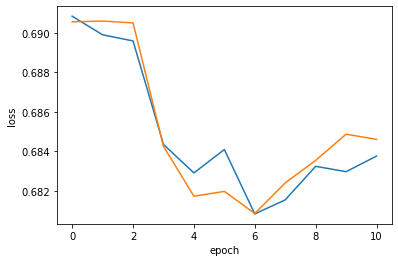

In [53]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [54]:
result = model.evaluate(x_test, y_test)
print("최종 예측 성공률(%): ", result[1]*100)

594/594 [==============================] - 2s 3ms/step - loss: 0.6902 - accuracy: 0.5105
최종 예측 성공률(%):  51.05262994766235


In [55]:
pred = model.predict(x_test)
pred = np.array(pred).reshape(-1,50)
pred

594/594 [==============================] - 1s 2ms/step


array([[0.4665227, 0.4665227, 0.4665227, ..., 0.4665227, 0.4665227,
        0.4665227],
       [0.4665227, 0.4665227, 0.4665227, ..., 0.4665227, 0.4665227,
        0.4665227],
       [0.4665227, 0.4665227, 0.4665227, ..., 0.4665227, 0.4665227,
        0.4665227],
       ...,
       [0.4665227, 0.4665227, 0.4665227, ..., 0.4665227, 0.4665227,
        0.4665227],
       [0.4665227, 0.4665227, 0.4665227, ..., 0.4665227, 0.4665227,
        0.4665227],
       [0.4665227, 0.4665227, 0.4665227, ..., 0.4665227, 0.4665227,
        0.4665227]], dtype=float32)

In [56]:
pred = model.predict(x_test)
pred = np.array(pred).reshape(-1,50)
print(pred.shape)

answer = []
for i,v in enumerate(pred):
    a = 0
    for j in v:
        a += j
    if a>=100:
        answer.append(1)
    else:
        answer.append(0)
    

print('Accuracy:', accuracy_score(y_test_data, answer)*100, '%')

594/594 [==============================] - 1s 2ms/step
(380, 50)
Accuracy: 51.05263157894737 %


In [57]:
x_train.shape

(57000, 50, 50, 1)

In [58]:
cnt = 0
for i in range(50):
    for j in range(50):
        if x_train[2][i][j] == x_train[100][i][j]:
            cnt += 1
cnt

1121